In [ ]:
#Implement a simple autoencoder to do blind unmixing of HSI Urban dataset.
#Refer the paper : Hyperspectral Unmixing Using a Neural Network Autoencoder
#not yet working model

In [1]:
#All imports 

import tensorflow as tf
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import scipy.io as sio
from sklearn.preprocessing import StandardScaler

from keras.layers import Input, Dense, ThresholdedReLU
from keras.models import Model
from keras.initializers import he_normal
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import regularizers
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
#hyperparameters 
#for now will use the best possibilities suggested by the research paper
#use Urban HSI data that is preprocessed with useless bands removed and 4 endmembers as ground truth. 
#http://lesun.weebly.com/hyperspectral-data-set.html
n_bands =  162
n_pixels = 307 * 307
n_endmember = 4 #use the 4 channel groundtruth for later comparison 

#hidden layers number of nodes 
n_hidden1 = 9 * n_endmember
n_hidden2 = 6 * n_endmember 
n_hidden3 = 3 * n_endmember
n_hidden4 =  n_endmember

#decoder with linear activation 
n_outputs = n_bands

learning_rate = 1
batch_size = 10
n_epochs = 10
l2_reg = 0.1
train_bool = True

In [3]:
"""
#construct the autoencoder layers 

#place holder for input with variable batch size
X = tf.placeholder(tf.float32, shape = [ None, n_bands])

#he_init initializer
he_init = tf.contrib.layers.variance_scaling_initializer()

#l2 regularizer to add to loss function

l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

#python partial function to define some of the arguments for dense function call 
my_dense_layer = partial(tf.layers.dense,
                         activation = tf.nn.relu, 
                         kernel_initializer= he_init, 
                         kernel_regularizer = l2_regularizer)

#all the layers definition

#encoder
hidden1 = my_dense_layer(X, n_hidden1, activation = tf.nn.sigmoid, name = "hidden_1")
hidden2 = my_dense_layer(hidden1,n_hidden2,activation = tf.nn.sigmoid, name = "hidden_2") 
hidden3 = my_dense_layer(hidden2, n_hidden3,activation = tf.nn.sigmoid , name = "hidden_3")
hidden4 = my_dense_layer(hidden3, n_hidden4,activation = tf.nn.sigmoid, name = "hidden_4")

# "encoded" is the encoded representation of the input
         
#add utility layers 
#batch normalization
hidden5 = tf.layers.batch_normalization(hidden4, training = train_bool) 
#dynamic soft thresholding fix to use keras layer for dynamic thresholding with learning parameter
hidden6 = my_dense_layer(hidden5, n_hidden4, activation = tf.nn.relu,name = "threshold")
#enforce ASC for now using softmax activation 
hidden7 = my_dense_layer(hidden6, n_hidden4, activation = tf.nn.softmax,name = "ASC")

#gaussian dropout 
hidden8 = tf.layers.dropout(hidden7,rate=0.5,training = train_bool)
    
#decoder 
outputs = my_dense_layer(hidden8, n_outputs, activation = None,use_bias=False, name = "output")

#start using MSE and later change it to use SID/ SAD as recommended in paper 

#reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) #MSE
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

#adding two tensors to get final loss 
loss = tf.add_n([reconstruction_loss] + reg_losses)

#recommended adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
training_op = optimizer.minimize(loss)
training_op = tf.group([training_op, update_ops])
"""


'\n#construct the autoencoder layers \n\n#place holder for input with variable batch size\nX = tf.placeholder(tf.float32, shape = [ None, n_bands])\n\n#he_init initializer\nhe_init = tf.contrib.layers.variance_scaling_initializer()\n\n#l2 regularizer to add to loss function\n\nl2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)\n\n#python partial function to define some of the arguments for dense function call \nmy_dense_layer = partial(tf.layers.dense,\n                         activation = tf.nn.relu, \n                         kernel_initializer= he_init, \n                         kernel_regularizer = l2_regularizer)\n\n#all the layers definition\n\n#encoder\nhidden1 = my_dense_layer(X, n_hidden1, activation = tf.nn.sigmoid, name = "hidden_1")\nhidden2 = my_dense_layer(hidden1,n_hidden2,activation = tf.nn.sigmoid, name = "hidden_2") \nhidden3 = my_dense_layer(hidden2, n_hidden3,activation = tf.nn.sigmoid , name = "hidden_3")\nhidden4 = my_dense_layer(hidden3, n_hidden4,activa

In [4]:
#load urban data 
#assumption data is downloaded and saved locally #TODO add script to download as prerequisite.
urban_mat = sio.loadmat('/Users/deivanaimeyyappan/Downloads/Urban_R162.mat')
data = np.array(urban_mat['Y'])
print (data.shape)
 # reshape data to 2D with one pixel of input for all bands at a time 
standardized_data = StandardScaler().fit_transform(data)
standardized_data = np.transpose(standardized_data)
print (standardized_data.shape)
standardized_data = standardized_data[0:90000]
print (standardized_data.shape)

(162, 94249)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(94249, 162)
(90000, 162)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
X = Input(shape=(n_bands,))
hidden1 = Dense(n_hidden1, input_dim = n_bands, kernel_initializer='he_normal', activation = 'sigmoid')(X)
hidden2 = Dense(n_hidden2, kernel_initializer='he_normal', activation = 'sigmoid')(hidden1)
hidden3 = Dense(n_hidden3, kernel_initializer='he_normal', activation = 'sigmoid')(hidden2)
hidden4  = Dense(n_hidden4, kernel_initializer='he_normal', activation = 'sigmoid')(hidden3)
hidden5_bn = BatchNormalization()(hidden4)# batchnormalization layer 
hidden6_t = ThresholdedReLU(theta=0.1)(hidden5_bn) #fix to add custom dynamic soft thresholding layer
hidden7_asc = Dense(n_hidden4, activation = 'softmax')(hidden6_t) #ASC constraint using softmax output 
# layers output activation is the abundance map 

hidden8_do = Dropout(0.2)(hidden7_asc) # gaussian drop out 
output = Dense(n_outputs, activation = None, use_bias = False, kernel_constraint = 'NonNeg')(hidden8_do) # non negative constraints for weight. 
#layers weights are the endmember signature. 
adam = Adam(lr=learning_rate, decay = 0.1)
autoencoder = Model(X, output)
autoencoder.compile(loss='mse', optimizer=adam)


In [6]:
autoencoder.fit(standardized_data,standardized_data, nb_epoch=n_epochs, batch_size=batch_size, verbose = 2)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/10
 - 33s - loss: 0.6320
Epoch 2/10
 - 32s - loss: 0.6079
Epoch 3/10
 - 29s - loss: 0.6050
Epoch 4/10
 - 31s - loss: 0.6049
Epoch 5/10
 - 30s - loss: 0.6037
Epoch 6/10
 - 32s - loss: 0.6041
Epoch 7/10
 - 31s - loss: 0.6036
Epoch 8/10
 - 31s - loss: 0.6035
Epoch 9/10
 - 31s - loss: 0.6036
Epoch 10/10
 - 29s - loss: 0.6028


In [ ]:
""" saver = tf.train.Saver()
init = tf.global_variables_initializer()
variables_names = [v.name for v in tf.trainable_variables()]
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range( n_pixels // batch_size ):
            start = iteration
            end = iteration + batch_size
            x_batch = np.transpose((np.reshape(standardized_data[start:end], (n_bands, batch_size))))
            _, tr_loss = sess.run([training_op,loss], feed_dict= {X: x_batch})
        if(epoch % 50 == 0):
           print('Step %i: Minibatch Loss: %f' % (epoch, tr_loss))
    save_path = saver.save(sess, "./my_model_final.ckpt")"""
    

In [11]:
#get weights of layer 8 corresponding to end member signature.
for layer in autoencoder.layers:
    print(layer.get_config())
    
print (len(autoencoder.layers))


{'batch_input_shape': (None, 162), 'dtype': 'float32', 'sparse': False, 'name': 'input_1'}
{'name': 'dense_1', 'trainable': True, 'batch_input_shape': (None, 162), 'dtype': 'float32', 'units': 36, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'normal', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'dense_2', 'trainable': True, 'units': 24, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'normal', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint':

[array([[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000

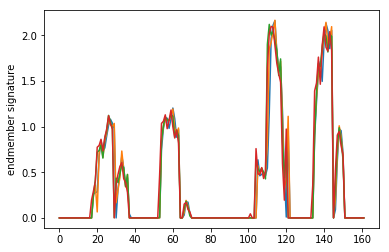

In [14]:
endmember_signature = autoencoder.layers[9].get_weights()
print(endmember_signature)
endmember_signature = np.reshape(endmember_signature, ( n_bands, n_endmember))
print(endmember_signature.shape)
plt.plot(endmember_signature)
plt.ylabel('endmember signature')
plt.show()

In [ ]:
"""
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    values = sess.run("output/kernel:0")
    values = np.transpose(values)
    plt.plot(values)
    plt.ylabel('endmember signature')
    plt.show()"""
   

(162, 4)


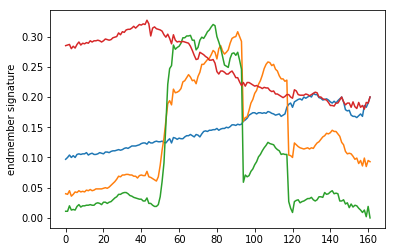

In [15]:
#get ground truth end member signature and end member abundance to check the performance of the trained vs test data. 

urban_gt = sio.loadmat('/Users/deivanaimeyyappan/Downloads/groundTruth/end4_groundTruth.mat')
urban_endmember_gt = urban_gt['M']
print (urban_endmember_gt.shape)
plt.plot(urban_endmember_gt)
plt.ylabel('endmember signature')
plt.show()


In [ ]:
"""#get the abundance fraction of pixel 0
with tf.Session() as sess:
    train_bool = False
    saver.restore(sess, "./my_model_final.ckpt")
    for iteration in range( n_pixels)
        activation = sess.run(hidden8,feed_dict={X:np.transpose(np.reshape(standardized_data[0],(n_bands,1)))})
        print(activation)"""

In [ ]:
#print abundance maps 
#get activation of layer 8 and plot abundance fraction
#still working on it. 

In [16]:
layer_name = 'dense_5'
intermediate_layer_model = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.get_layer(layer_name).output)
print (standardized_data.shape)

intermediate_output = intermediate_layer_model.predict(standardized_data)
print(intermediate_output.shape)

(90000, 162)
(90000, 4)
